In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [3]:
data =  pd.read_csv('/kaggle/input/microsoft-lifetime-stocks-dataset/MSFT.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.062549,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.064783,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065899,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.064224,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.063107,47894400


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8525 entries, 0 to 8524
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8525 non-null   object 
 1   Open       8525 non-null   float64
 2   High       8525 non-null   float64
 3   Low        8525 non-null   float64
 4   Close      8525 non-null   float64
 5   Adj Close  8525 non-null   float64
 6   Volume     8525 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 466.3+ KB


array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Adj Close'}>,
        <Axes: title={'center': 'Volume'}>]], dtype=object)

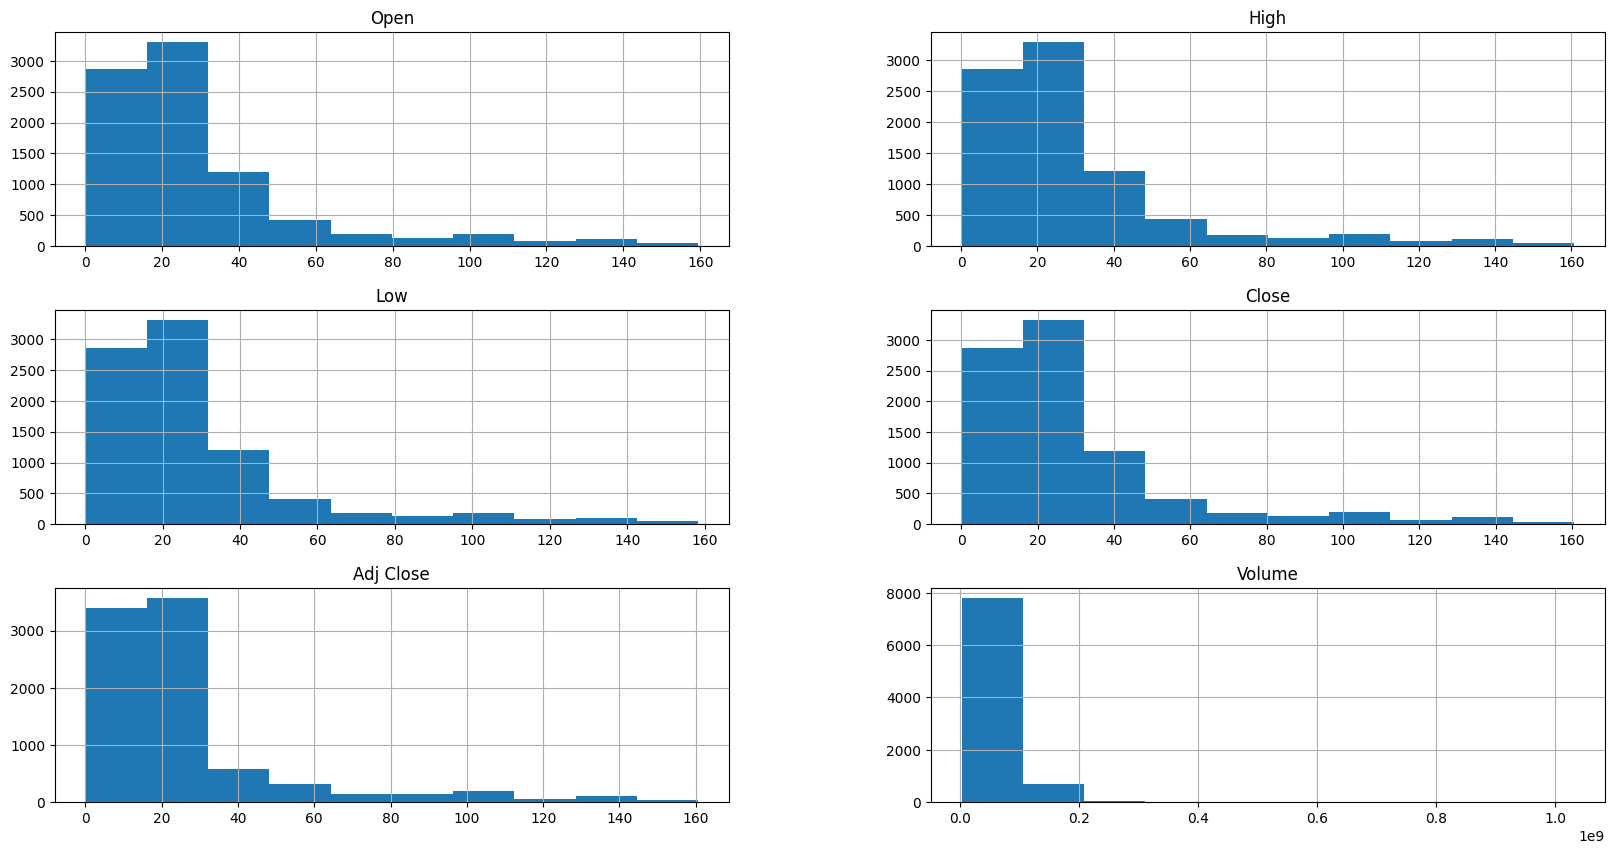

In [5]:
data.hist(figsize =(20,10) )

In [6]:
data.rename(columns = {'Open':'Opening Price','High':'Highest Price','Low':'Lowest Price','Close':'Closing Price','Adj Close':'Adjusted Close Price'}, inplace = True)

<Axes: >

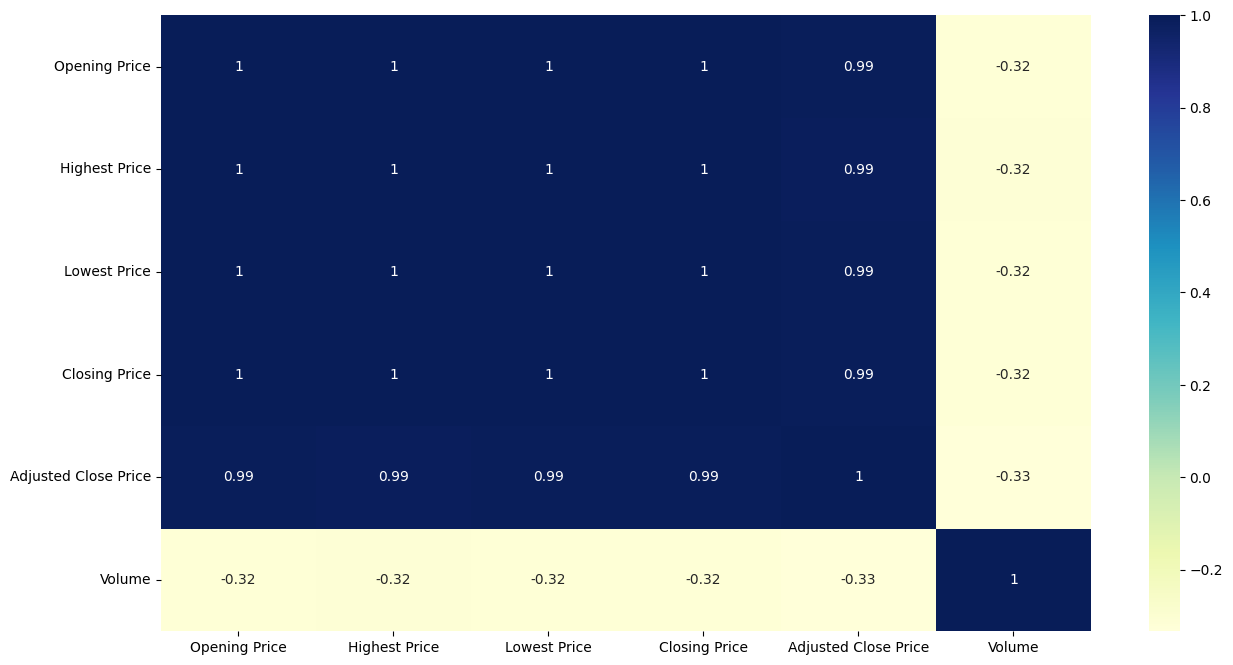

In [7]:
plt.figure(figsize=(15,8))
sns.heatmap(data.drop(['Date'],axis=1).corr(),annot = True, cmap='YlGnBu')

In [8]:
data['Range'] = data['Highest Price']-data['Lowest Price']

data['Daily Average'] = (data['Highest Price']+data['Lowest Price']+data['Closing Price']+data['Opening Price'])/4
data['Market Capitalization'] = data['Closing Price'] * data['Volume']

In [9]:
data['Target'] = data['Closing Price'].shift(-1)

In [10]:
window = 10
data['SMA'] = data['Closing Price'].rolling(window=window).mean()
data['EMA'] = data['Closing Price'].ewm(span=window, adjust=False).mean()

delta = data['Closing Price'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
data['RSI'] = rsi

k_window = 10
d_window = 3   

low_min = data['Lowest Price'].rolling(window=k_window).min()
high_max = data['Highest Price'].rolling(window=k_window).max()

k = 100 * ((data['Closing Price'] - low_min) / (high_max - low_min))
data['%K'] = k

data['%D'] = data['%K'].rolling(window=d_window).mean()

In [11]:
data.isna().sum()

Date                      0
Opening Price             0
Highest Price             0
Lowest Price              0
Closing Price             0
Adjusted Close Price      0
Volume                    0
Range                     0
Daily Average             0
Market Capitalization     0
Target                    1
SMA                       9
EMA                       0
RSI                       9
%K                        9
%D                       11
dtype: int64

In [12]:
data = data.fillna(method='ffill') 
data = data.fillna(method='bfill') 

array([[<Axes: title={'center': 'Opening Price'}>,
        <Axes: title={'center': 'Highest Price'}>,
        <Axes: title={'center': 'Lowest Price'}>,
        <Axes: title={'center': 'Closing Price'}>],
       [<Axes: title={'center': 'Adjusted Close Price'}>,
        <Axes: title={'center': 'Volume'}>,
        <Axes: title={'center': 'Range'}>,
        <Axes: title={'center': 'Daily Average'}>],
       [<Axes: title={'center': 'Market Capitalization'}>,
        <Axes: title={'center': 'Target'}>,
        <Axes: title={'center': 'SMA'}>, <Axes: title={'center': 'EMA'}>],
       [<Axes: title={'center': 'RSI'}>, <Axes: title={'center': '%K'}>,
        <Axes: title={'center': '%D'}>, <Axes: >]], dtype=object)

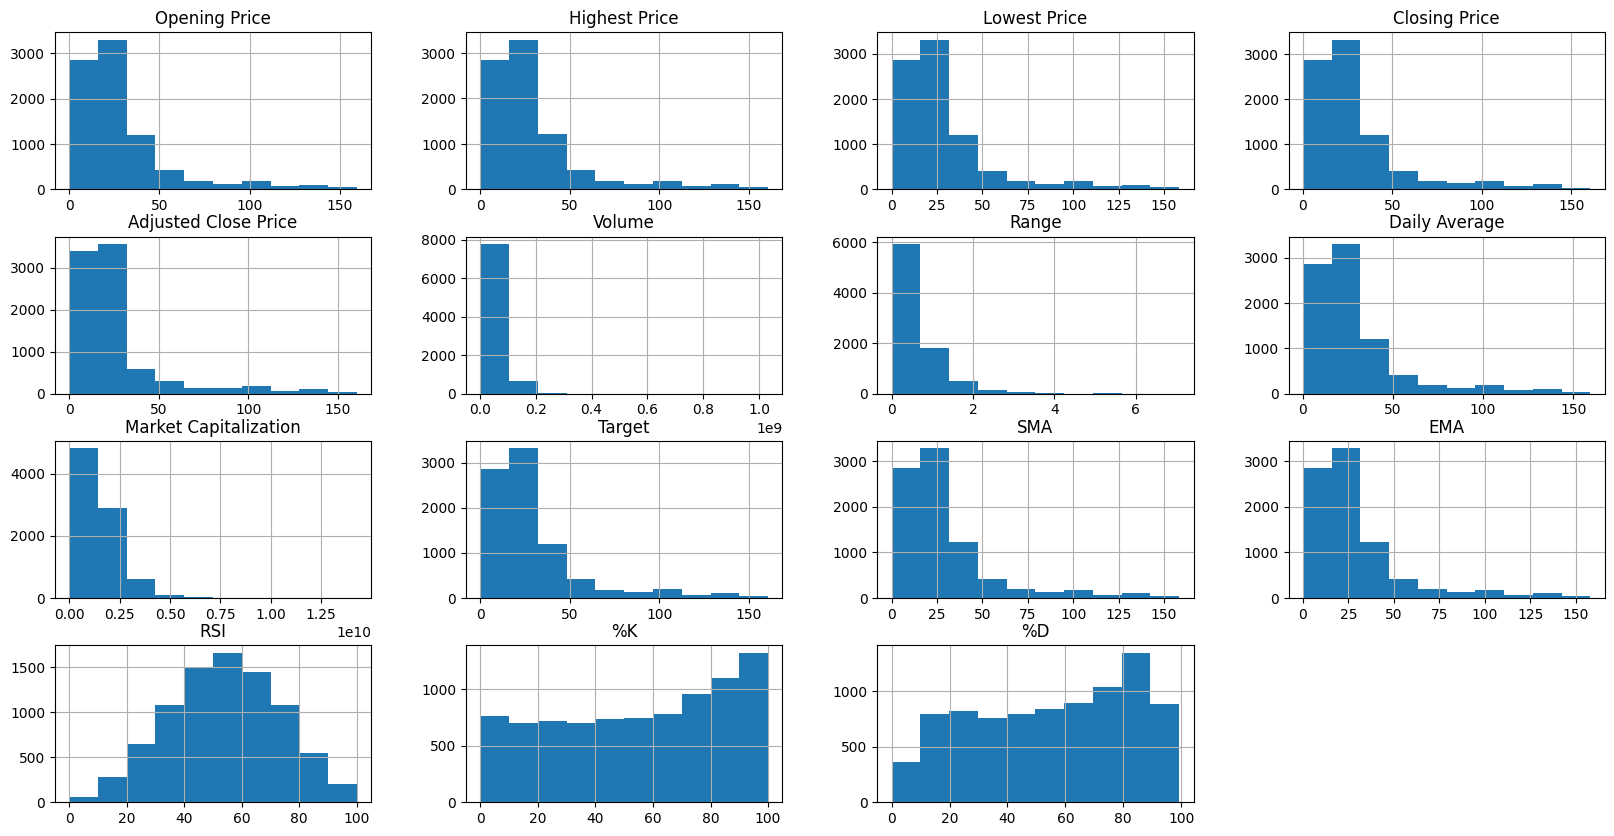

In [13]:
data.hist(figsize =(20,10) )

<Axes: >

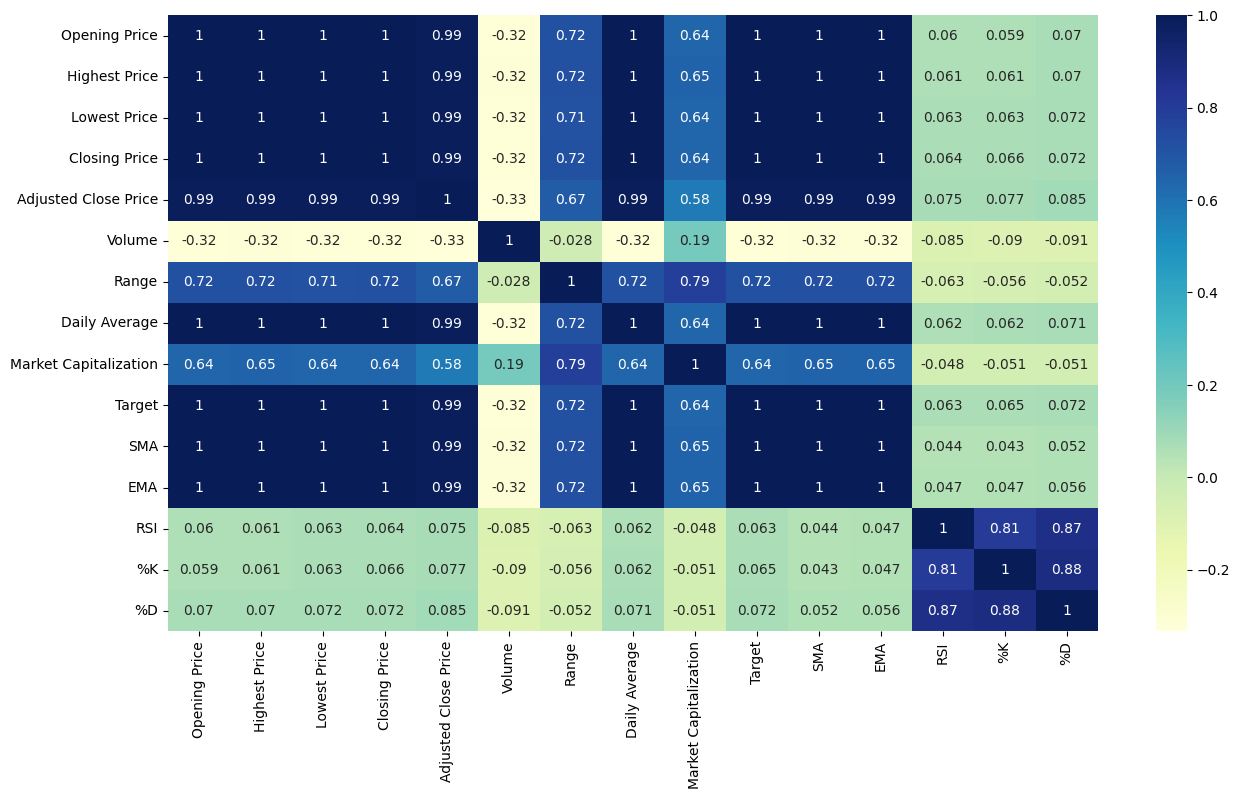

In [14]:
plt.figure(figsize=(15,8))
sns.heatmap(data.drop(['Date'],axis=1).corr(),annot = True, cmap='YlGnBu')

In [15]:
data.head()

,Date,Opening Price,Highest Price,Lowest Price,Closing Price,Adjusted Close Price,Volume,Range,Daily Average,Market Capitalization,Target,SMA,EMA,RSI,%K,%D
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.062549,1031788800,0.013021,0.093967,1.003126e+08,0.100694,0.096354,0.097222,44.000553,41.17368,44.97231
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.064783,308160000,0.005209,0.099392,3.102986e+07,0.102431,0.096354,0.097853,44.000553,41.17368,44.97231
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065899,133171200,0.002605,0.101780,1.364086e+07,0.099826,0.096354,0.098686,44.000553,41.17368,44.97231
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.064224,67766400,0.004341,0.101128,6.764849e+06,0.098090,0.096354,0.098893,44.000553,41.17368,44.97231
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.063107,47894400,0.003472,0.098958,4.697962e+06,0.095486,0.096354,0.098747,44.000553,41.17368,44.97231


In [16]:
data.columns

Index(['Date', 'Opening Price', 'Highest Price', 'Lowest Price',
       'Closing Price', 'Adjusted Close Price', 'Volume', 'Range',
       'Daily Average', 'Market Capitalization', 'Target', 'SMA', 'EMA', 'RSI',
       '%K', '%D'],
      dtype='object')

In [17]:
feature_columns = ['Opening Price', 'Highest Price', 'Lowest Price','Adjusted Close Price', 'Volume', 'Range',
       'Daily Average', 'Market Capitalization','SMA', 'EMA', 'RSI', '%K', '%D']
target_column = 'Target'

# Extract features and target
X = data[feature_columns].values
y = data[target_column].values

# Normalize the features (scaling between 0 and 1 is often recommended for LSTM models)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Define the sequence length (e.g., number of days to look back for predictions)
sequence_length = 10  # You can adjust this as needed

# Create sequences for training
X_sequences, y_sequences = [], []

for i in range(len(X) - sequence_length):
    X_sequences.append(X[i:i + sequence_length])
    y_sequences.append(y[i + sequence_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, shuffle=False)
X_train, X_temp, y_train, y_temp = train_test_split(X_sequences, y_sequences, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [18]:
# train_data = data.iloc[:,5:6].values

In [19]:
# scaler = MinMaxScaler(feature_range = (0,1))
# train_data = scaler.fit_transform(train_data)
# train_data.shape

In [20]:
# X_train = []
# y_train = []

# for i in range (60,8525):
#     X_train.append(train_data[i-60:i,0])
#     y_train.append(train_data[i,0])
    

# X_train, y_train = np.array(X_train), np.array(y_train)

In [21]:
# X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
# X_train.shape

In [22]:
# X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [23]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae','mse'])

In [27]:
X_train = X_train.reshape(X_train.shape[0], 10, 13)
X_val = X_val.reshape(X_val.shape[0], 10, 13)


In [28]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
187/187 - 19s - loss: 941.4017 - mae: 20.6357 - mse: 941.4017 - val_loss: 902.0693 - val_mae: 19.4949 - val_mse: 902.0693 - 19s/epoch - 99ms/step
Epoch 2/100
187/187 - 8s - loss: 808.2415 - mae: 18.7911 - mse: 808.2415 - val_loss: 888.3741 - val_mae: 19.6542 - val_mse: 888.3741 - 8s/epoch - 42ms/step
Epoch 3/100
187/187 - 8s - loss: 805.7323 - mae: 18.9749 - mse: 805.7323 - val_loss: 888.4874 - val_mae: 19.6329 - val_mse: 888.4874 - 8s/epoch - 42ms/step
Epoch 4/100
187/187 - 8s - loss: 804.9435 - mae: 18.9078 - mse: 804.9435 - val_loss: 888.2399 - val_mae: 19.6874 - val_mse: 888.2399 - 8s/epoch - 42ms/step
Epoch 5/100
187/187 - 8s - loss: 806.7094 - mae: 18.9592 - mse: 806.7094 - val_loss: 888.2650 - val_mae: 19.6802 - val_mse: 888.2650 - 8s/epoch - 43ms/step
Epoch 6/100
187/187 - 8s - loss: 804.9966 - mae: 18.8982 - mse: 804.9966 - val_loss: 888.0823 - val_mae: 19.7828 - val_mse: 888.0823 - 8s/epoch - 43ms/step
Epoch 7/100
187/187 - 8s - loss: 804.4825 - mae: 18.9564 - mse

<function matplotlib.pyplot.show(close=None, block=None)>

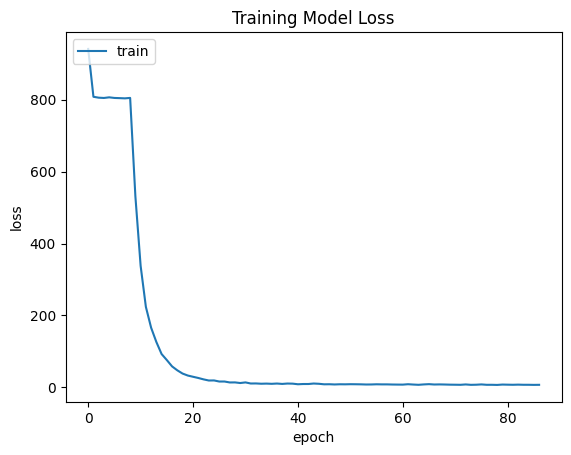

In [29]:
plt.plot(hist.history['loss'])
plt.title('Training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc = 'upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

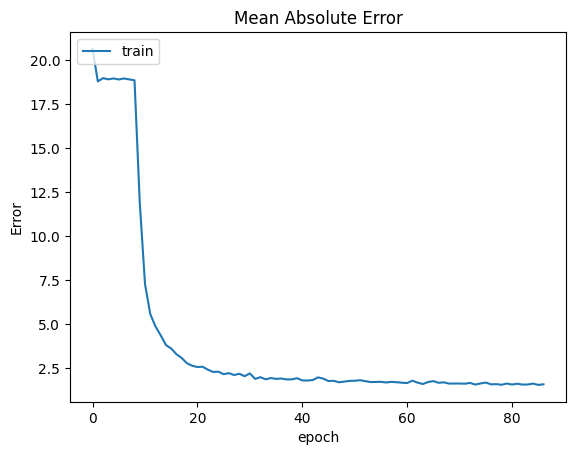

In [30]:
plt.plot(hist.history['mae'])
plt.title('Mean Absolute Error')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend(['train'],loc = 'upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

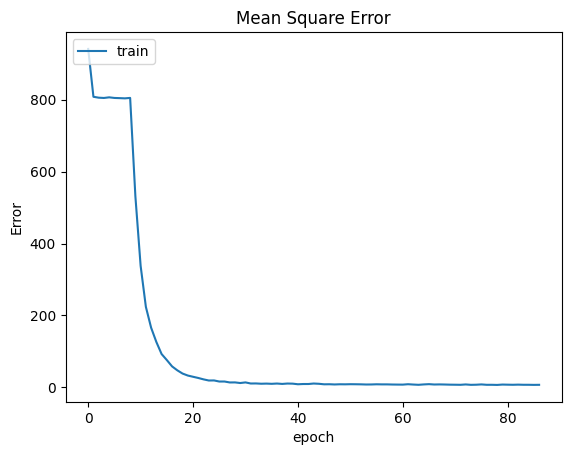

In [31]:
plt.plot(hist.history['mse'])
plt.title('Mean Square Error')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend(['train'],loc = 'upper left')
plt.show

In [32]:
y_pred = model.predict(X_test)

27/27 [==============================] - 2s 12ms/step


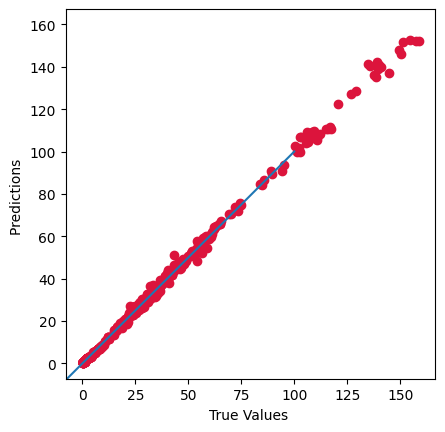

In [33]:
plt.scatter(y_test, y_pred,c='crimson')
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.plot([-100, 100], [-100, 100])

In [34]:
model.save('/kaggle/working/output/LSTM_model_phase_3.h5')